# Fun with Conditional Variational Autoencoders

This is a starter kernel to understand the main principles of conditional variational autoencoders. PyTorch will be used for modelling.

### **Please, give this kernel an upvote if it's helpful for you.**

You can find explanation of the vanilla and variational autoencoders in the following notebook:

* [Fun with Variational Autoencoders](https://www.kaggle.com/averkij/variational-autoencoder-and-faces-generation/edit/run/28076587)

In this kernel we will discuss the conditional variation of the autoencoder and build a model, train it and analyse the latent space with t-SNE technique.

![architecture](https://www.mdpi.com/sensors/sensors-19-02528/article_deploy/html/images/sensors-19-02528-g002.png)


# The dataset

We will use the MNIST dataset because it's simple and small. You can fork this notebook and experiment with the dataset you like. Fashion MNIST, etc.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
batch_size = 128
learning_rate = 0.005
input_size = 28*28
hidden_size = 64
labels_length = 10

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
dataset = MNIST('./data', transform=transform, download=True)
train_data, test_data = data.random_split(dataset, (50000,10000))

train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=6,persistent_workers=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2,persistent_workers=True)

In [6]:
#helper functions
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()
    
def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size + labels_length, 64),
            #nn.ReLU(True),
            #nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size))
             
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + labels_length, 64),
            nn.ReLU(True),
            #nn.Linear(64, 128),
            #nn.ReLU(True),
            nn.Linear(64, input_size),
            nn.Tanh())

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x,labels),dim=1)
        return self.encoder(x)
    
    def decode(self, x, labels):
        x = torch.cat((x,labels),dim=1)
        return self.decoder(x)

    def forward(self, x, labels):
        x = self.encode(x,labels)
        x = self.decode(x,labels)
        return x

In [8]:
model = autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer, is_cvae):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)
        optimizer.zero_grad()
        if is_cvae:
            outputs, mu, logvar = model(inputs,labels)
            loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
            loss.backward()
        else:
            outputs = model(inputs,labels)
            loss = criterion(outputs, inputs.view(-1,28*28))
            loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss
  
def eval_epoch(model, val_loader, criterion, is_cvae):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    inp,out = [],[]
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        with torch.set_grad_enabled(False):
            if is_cvae:
                outputs, mu, logvar = model(inputs,labels)
                loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
                loss.backward()
            else:
                outputs = model(inputs,labels)
                loss = criterion(outputs, inputs.view(-1,28*28))
                inp,out = inputs, outputs

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
        
    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].cpu(),out[0].cpu()],28,28,1,2)

    val_loss = running_loss / processed_size
    return val_loss
  
def train(train_loader, val_loader, model, epochs, batch_size, is_cvae=False):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:        
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt, is_cvae)
            print("loss", train_loss)   
            opt.param_groups[0]['lr'] = opt.param_groups[0]['lr'] * 0.9         
            if epoch%10 == 0:
                val_loss =  eval_epoch(model, val_loader, criterion, is_cvae)
            history.append((train_loss, val_loss))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))            
    return history

In [10]:

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.19220792320251465


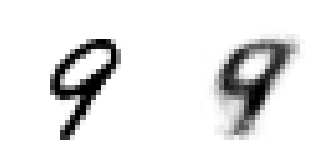

epoch:   5%|▌         | 1/20 [00:04<01:29,  4.73s/it]


Epoch 001 train_loss: 0.1922 val_loss 0.1186


epoch:  10%|█         | 2/20 [00:07<01:00,  3.37s/it]

loss 0.10958203569173813

Epoch 002 train_loss: 0.1096 val_loss 0.1186


epoch:  15%|█▌        | 3/20 [00:09<00:48,  2.84s/it]

loss 0.1006048895740509

Epoch 003 train_loss: 0.1006 val_loss 0.1186


epoch:  20%|██        | 4/20 [00:11<00:41,  2.61s/it]

loss 0.09643590901851654

Epoch 004 train_loss: 0.0964 val_loss 0.1186


epoch:  25%|██▌       | 5/20 [00:13<00:36,  2.44s/it]

loss 0.09288576588392258

Epoch 005 train_loss: 0.0929 val_loss 0.1186


epoch:  30%|███       | 6/20 [00:16<00:33,  2.39s/it]

loss 0.09053645291566849

Epoch 006 train_loss: 0.0905 val_loss 0.1186


epoch:  35%|███▌      | 7/20 [00:18<00:31,  2.39s/it]

loss 0.0888502326631546

Epoch 007 train_loss: 0.0889 val_loss 0.1186


epoch:  40%|████      | 8/20 [00:20<00:28,  2.34s/it]

loss 0.08757006654024124

Epoch 008 train_loss: 0.0876 val_loss 0.1186


epoch:  45%|████▌     | 9/20 [00:23<00:25,  2.35s/it]

loss 0.0866194184422493

Epoch 009 train_loss: 0.0866 val_loss 0.1186


epoch:  50%|█████     | 10/20 [00:25<00:22,  2.29s/it]

loss 0.0857725300359726

Epoch 010 train_loss: 0.0858 val_loss 0.1186
loss 0.08499155044078827


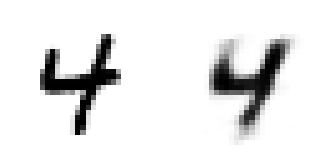

epoch:  55%|█████▌    | 11/20 [00:28<00:24,  2.69s/it]


Epoch 011 train_loss: 0.0850 val_loss 0.0854


epoch:  60%|██████    | 12/20 [00:30<00:20,  2.51s/it]

loss 0.08439338928699494

Epoch 012 train_loss: 0.0844 val_loss 0.0854


epoch:  65%|██████▌   | 13/20 [00:33<00:16,  2.40s/it]

loss 0.08384929310321808

Epoch 013 train_loss: 0.0838 val_loss 0.0854


epoch:  70%|███████   | 14/20 [00:35<00:13,  2.32s/it]

loss 0.08336858618021012

Epoch 014 train_loss: 0.0834 val_loss 0.0854


epoch:  75%|███████▌  | 15/20 [00:37<00:11,  2.28s/it]

loss 0.08296215470075607

Epoch 015 train_loss: 0.0830 val_loss 0.0854


epoch:  80%|████████  | 16/20 [00:39<00:08,  2.23s/it]

loss 0.08260919484853745

Epoch 016 train_loss: 0.0826 val_loss 0.0854


epoch:  85%|████████▌ | 17/20 [00:41<00:06,  2.17s/it]

loss 0.0822748525238037

Epoch 017 train_loss: 0.0823 val_loss 0.0854


epoch:  90%|█████████ | 18/20 [00:43<00:04,  2.15s/it]

loss 0.08198839887142181

Epoch 018 train_loss: 0.0820 val_loss 0.0854


epoch:  95%|█████████▌| 19/20 [00:45<00:02,  2.14s/it]

loss 0.0817336863875389

Epoch 019 train_loss: 0.0817 val_loss 0.0854


epoch: 100%|██████████| 20/20 [00:47<00:00,  2.40s/it]

loss 0.08151813370704651

Epoch 020 train_loss: 0.0815 val_loss 0.0854


In [11]:
history = train(train_dataset, val_dataset, model=model, epochs=1, batch_size=128, is_cvae=False)

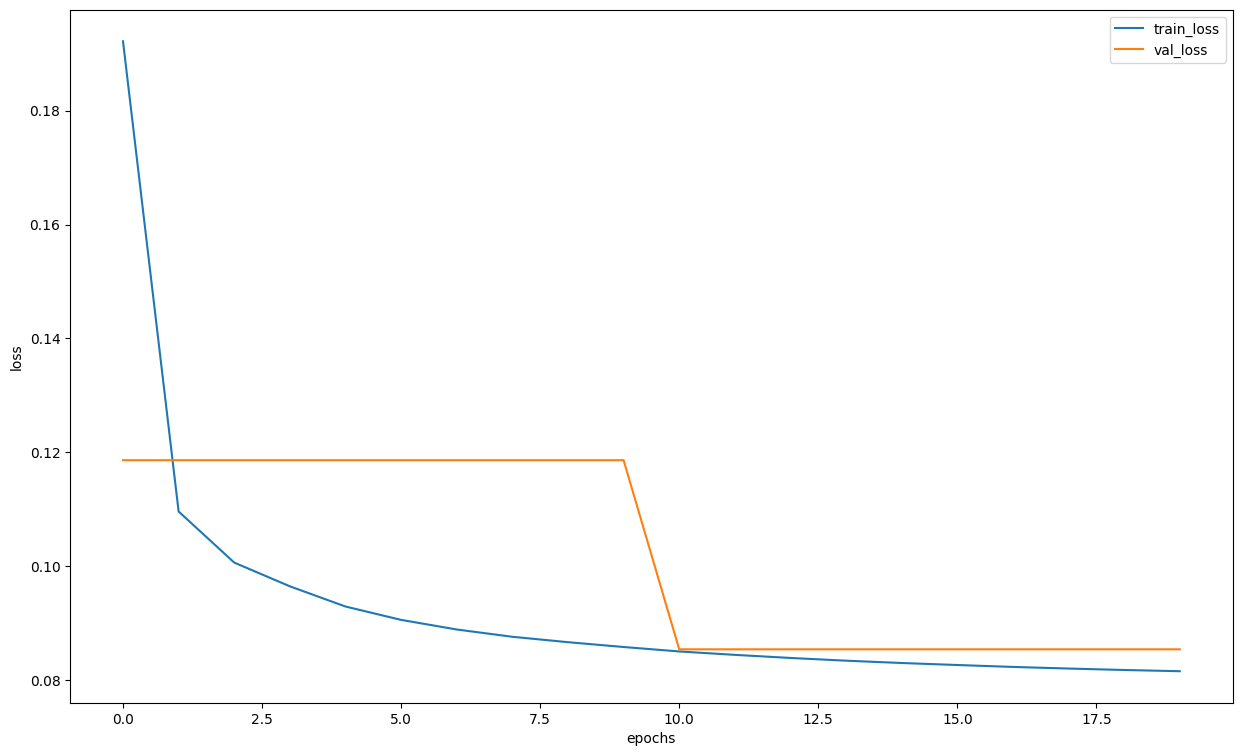

In [12]:
plot_loss(history)

# Sampling

Now we can try to get not the random pictures, but the numbers we want to generate. Let's say numbers from 0 to 9.

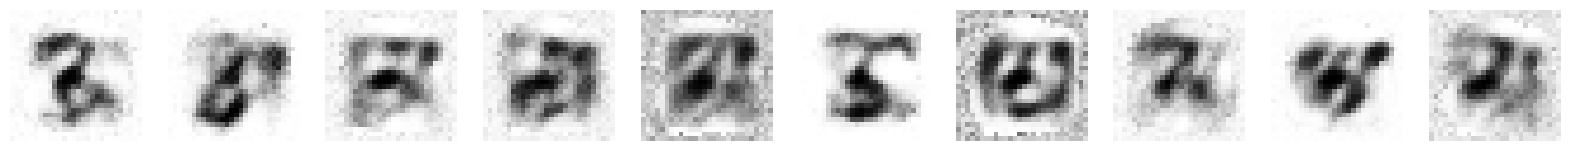

In [13]:
with torch.set_grad_enabled(False):
    number_for_generation=[0,1,2,3,4,5,6,7,8,9]
    inputs = torch.FloatTensor(np.random.randn(10*28*28).reshape(-1,28,28))
    inputs = inputs.to(DEVICE)
    label = one_hot(number_for_generation,9).to(DEVICE)
    outputs = model(inputs,label)
    plot_gallery(outputs.cpu(),28,28,1,10)

# Exploring the latent space using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. Let's use it and plot the results.

In [14]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

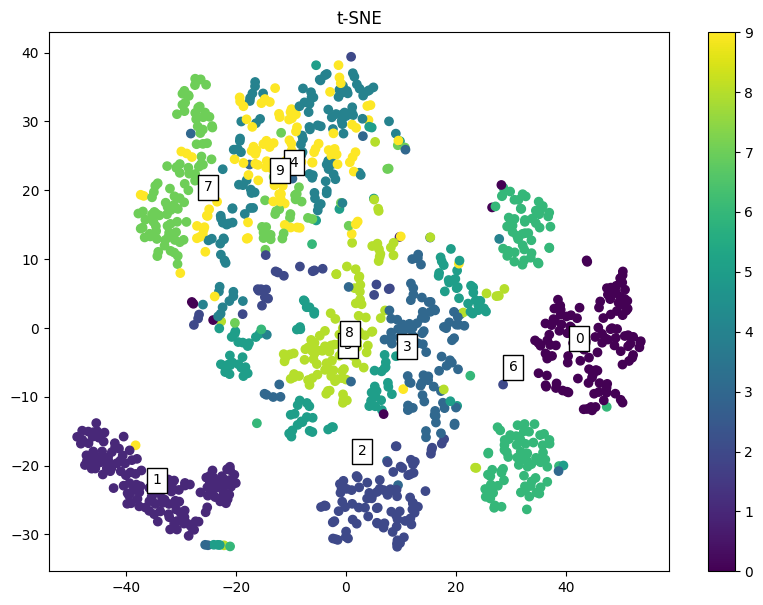

In [25]:
plot_tsne(net=model, mode='dots', count=1000, is_cvae=False)

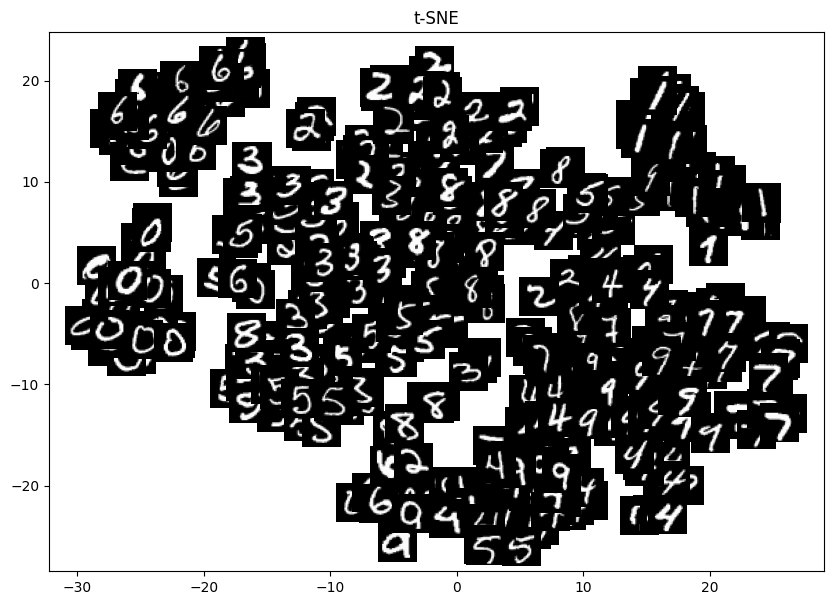

In [16]:
plot_tsne(net=model, mode='imgs', count=300)

# Conditional Variational Autoencoder

In [17]:
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size=20):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, labels):
        torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        #targets = one_hot(targets,labels_length-1).float().to(DEVICE)
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=20):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

In [18]:
cvae = CVAE(28*28).to(DEVICE)

In [19]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]    
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), 28*28)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)            
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],28,28,1,2)    

    losses.append((sum(loss_sum)/len(loss_sum)).item())

In [20]:
def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=50):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

In [ ]:
history = train_cvae(cvae, train_dataset, val_dataset)

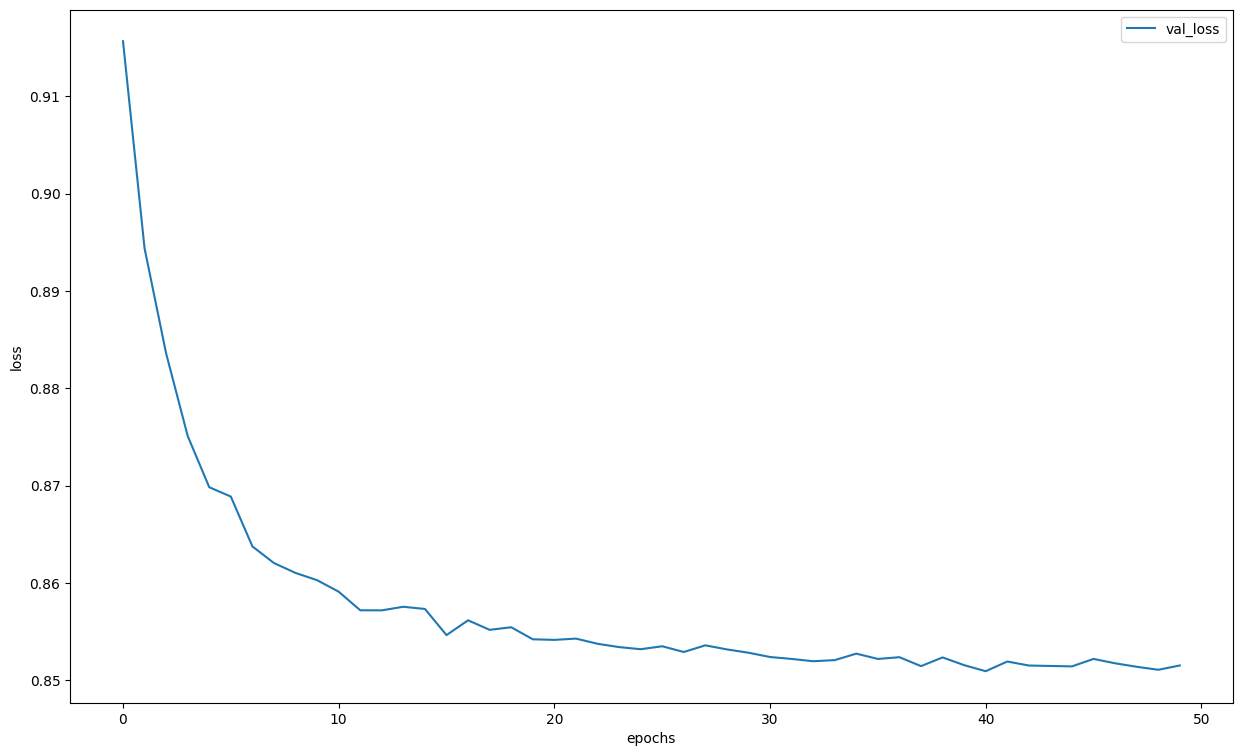

In [ ]:
val_loss = history
plt.figure(figsize=(15, 9))
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Plotting CVAE latent space using t-SNE

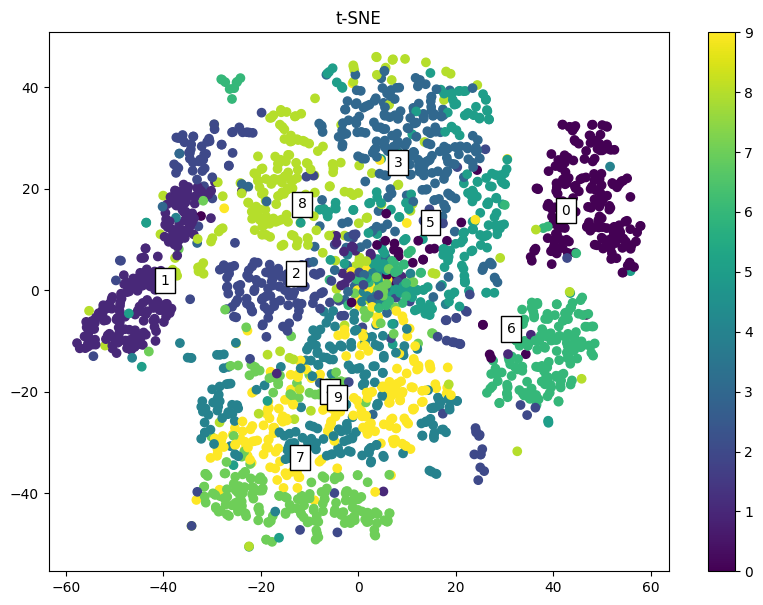

In [ ]:
plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)

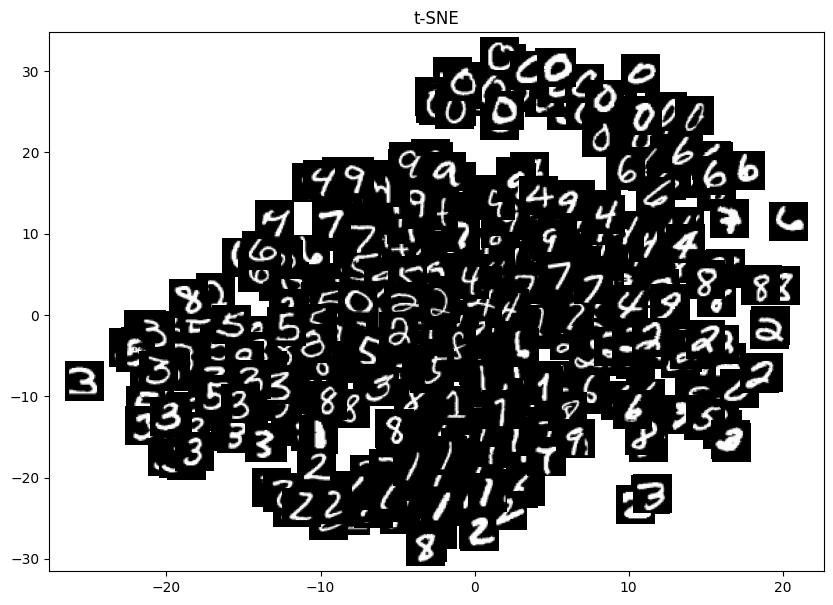

In [ ]:
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)

# Conclusion

Optimizing both **reconstruction** loss and **KL divergence** loss together results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin (compare the axes with the original).

Cool pic:

![https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif](https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif)